## Predicting the fare and tips using weather, season and time 
+ Give the recommendation base on the weather, season, and time 
+ Predicting the best time to drive make money
1. Model choosen
+ Linear Regression

In [1]:

from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 ML Model")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/30 02:42:38 WARN Utils: Your hostname, TRANG, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/30 02:42:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/30 02:42:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Linear regression for fare prediction
tips_weather = spark.read.parquet("data/training/tips_and_weather.parquet")
fare_weather = spark.read.parquet("data/training/fare_and_weather.parquet")  

In [3]:
tips_weather.count(), fare_weather.count()

(5517, 5518)

In [4]:
tips_weather.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- avg_tip_amount: double (nullable = true)
 |-- avg_air_temperature: double (nullable = true)
 |-- avg_dew_point: double (nullable = true)
 |-- avg_precipitation: double (nullable = true)



In [5]:
holiday = spark.read.parquet("data/training/taxi_on_holiday.parquet")  
non_holiday = spark.read.parquet("data/training/taxi_on_non_holiday.parquet")  

In [6]:
holiday.filter(holiday["payment_type"]==2).show(5, truncate=False)

+-----------+----------+------------+------------+------------+-------------------+-------------------+----+-----------+----------+----+
|fare_amount|tip_amount|payment_type|DOLocationID|PULocationID|pickup_datetime    |dropoff_datetime   |hour|pickup_date|date      |name|
+-----------+----------+------------+------------+------------+-------------------+-------------------+----+-----------+----------+----+
|13.5       |0.0       |2           |230         |113         |2024-10-31 07:16:42|2024-10-31 07:27:37|7   |2024-10-31 |2024-10-31|NA  |
|54.1       |0.0       |2           |181         |138         |2024-10-31 00:00:34|2024-10-31 00:37:39|0   |2024-10-31 |2024-10-31|NA  |
|7.2        |0.0       |2           |140         |236         |2024-10-31 00:49:02|2024-10-31 00:53:55|0   |2024-10-31 |2024-10-31|NA  |
|5.8        |0.0       |2           |141         |236         |2024-10-31 00:30:59|2024-10-31 00:34:57|0   |2024-10-31 |2024-10-31|NA  |
|21.2       |0.0       |2           |263 

In [7]:
from pyspark.sql.functions import when, col
from pyspark.sql import functions as F


In [8]:
holiday = (
    holiday
    # Create binary payment group: 1 for cash, 0 for non-cash
    .withColumn("payment_group", when(col("payment_type") == 1, 1).otherwise(0))
    
    # Keep tip only for cash payments, else 0
    .withColumn(
        "tip_amount",
        when(col("payment_type") == 1, col("tip_amount")).otherwise(0)
    )
    
    .drop("pickup_date")
)

print(
    "Shape after aggregating holiday fares and tips:",
    (holiday.count(), len(holiday.columns))
)

Shape after aggregating holiday fares and tips: (1460436, 11)


In [9]:
non_holiday = (
    non_holiday
    # Create binary payment group: 1 for cash, 0 for non-cash
    .withColumn("payment_group", when(col("payment_type") == 1, 1).otherwise(0))
    
    # Keep tip only for cash payments, else 0
    .withColumn(
        "tip_amount",
        when(col("payment_type") == 1, col("tip_amount")).otherwise(0)
    )
    
)
print(
    "Shape after aggregating non holiday fares and tips:",
    (holiday.count(), len(holiday.columns))
)

Shape after aggregating non holiday fares and tips: (1460436, 11)


In [10]:
non_holiday.printSchema()
holiday.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- hour: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- name: string (nullable = true)
 |-- payment_group: integer (nullable = false)

root
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- hour: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- name: string (nullable = true)
 |-- payment_group: integer (nullable = false)



In [11]:
# Simply stack rows
from pyspark.sql.functions import lit

non_holiday = non_holiday.withColumnRenamed("pickup_date", "date")

print(
    "Shape after changin pickup date to date:",
    (non_holiday.count(), len(non_holiday.columns))
)
# Flag the holiday instead of using the holiday name (I was stupid)
holiday = holiday.withColumn("is_holiday", lit(1))
non_holiday = non_holiday.withColumn("is_holiday", lit(0))
merged = holiday.unionByName(non_holiday)
merged = merged.drop("name")
print(
    "Shape after merging holiday and non-holiday data:",
    (merged.count(), len(merged.columns))
)
    

Shape after changin pickup date to date: (27048521, 11)
Shape after merging holiday and non-holiday data: (28508957, 11)


In [12]:
tips_df = (
    merged
    # Keep only cash payments
    .filter(col("payment_group") == 1)
    
    # Drop fare amount, we only care about tips
    .drop("fare_amount")
    
    # Aggregate average tip by hour, date, and is_holiday
    .groupBy("hour", "date", "is_holiday")
    .agg(F.avg("tip_amount").alias("avg_tip_amount"))
    
    # Sort results
    .orderBy("date", "hour", "is_holiday")
)

print(
    "Shape after aggregating tips:",
    (tips_df.count(), len(tips_df.columns))
)

Shape after aggregating tips: (5807, 4)


In [13]:
fare_df = (
    merged
    # Drop tip_amount since we only care about fares
    .drop("tip_amount")
    
    # Aggregate average fare by hour, date, and is_holiday
    .groupBy("hour", "date", "is_holiday")
    .agg(F.avg("fare_amount").alias("avg_fare_amount"))
    
    # Sort results
    .orderBy("date", "hour", "is_holiday")
)

print(
    "Shape after aggregating fares:",
    (fare_df.count(), len(fare_df.columns))
)

Shape after aggregating fares: (5807, 4)


In [14]:
tips_df.printSchema()

root
 |-- hour: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- is_holiday: integer (nullable = false)
 |-- avg_tip_amount: double (nullable = true)



In [15]:
# Join fare_df with fare_weather on date, hour, and avg_fare_amount
fare = fare_df.join(
    fare_weather,
    on=["avg_fare_amount", "date", "hour"],
    how="outer"
)

# Filter out fares greater than 200
fare = fare.filter(col("avg_fare_amount") <= 200)

# Print schema and shape
fare.printSchema()
print(
    "Shape after joining and filtering fares:",
    (fare.count(), len(fare.columns))
)

root
 |-- avg_fare_amount: double (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- avg_dew_point: double (nullable = true)
 |-- avg_precipitation: double (nullable = true)



Shape after joining and filtering fares: (5810, 6)


In [16]:
tip = (
    tips_df
    .join(tips_weather, ["avg_tip_amount", "date", "hour"], "outer")
    .drop("avg_air_temperature", "avg_air_pressure", "precip_happened")
)
print(
    "Shape after joining tips with weather and dropping features:",
    (tip.count(), len(tip.columns))
)

Shape after joining tips with weather and dropping features: (5808, 6)


In [17]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit


### Fare 


#### 1. Random Forest Regressor

In [18]:
fare = fare.withColumn("hour", col("hour").cast("int"))

fare_pd = fare.toPandas()

In [ ]:
fare_pd['date'] = pd.to_datetime(fare_pd['date'])
fare_pd['date'] = pd.to_datetime(fare_pd['date'])

# Extract month
fare_pd['month'] = fare_pd['date'].dt.month

def date_to_season(date):
    """
    Map a single date to its corresponding season.

    Args:
        date (pd.Timestamp): A pandas timestamp object.

    Returns:
        str: The season label ('autumn', 'winter', 'spring', or 'unknown').
    """
    if pd.Timestamp('2024-09-01') <= date <= pd.Timestamp('2024-12-15'):
        return 'autumn'
    elif pd.Timestamp('2024-12-15') < date <= pd.Timestamp('2025-03-15'):
        return 'winter'
    elif pd.Timestamp('2025-03-15') < date <= pd.Timestamp('2025-05-31'):
        return 'spring'
    else:
        return 'unknown'  # Optional: handle dates outside range

# Apply season mapping
fare_pd['season'] = fare_pd['date'].apply(date_to_season)

# Extract weekday (0=Monday, 6=Sunday)
fare_pd['weekday'] = fare_pd['date'].dt.weekday

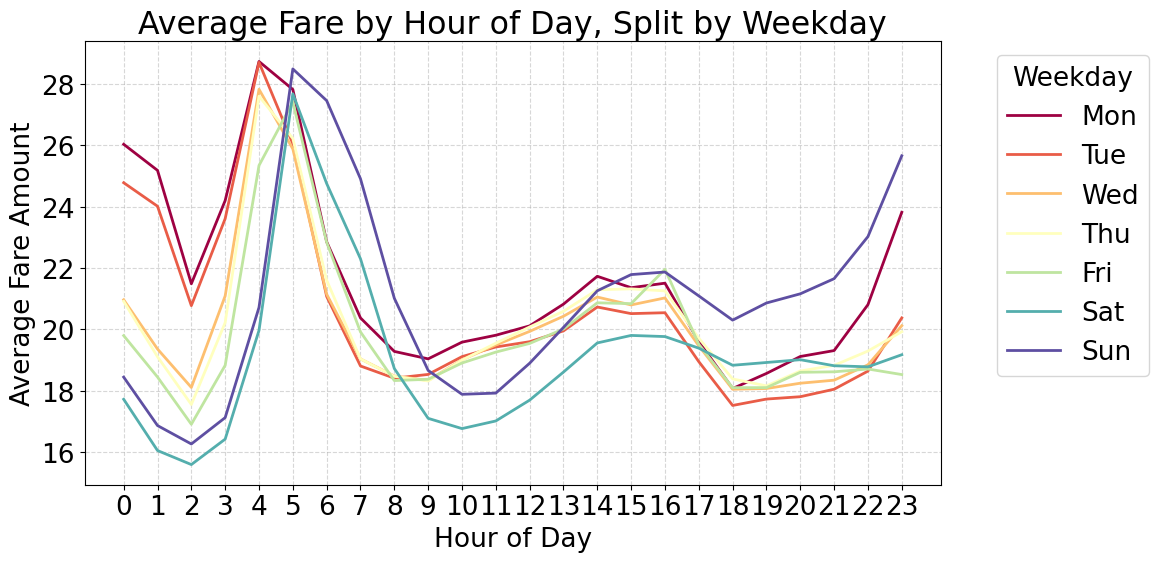

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Checking if weekday effect fare amount
plt.rcParams.update({"font.size": 19})
# Group by weekday + hour and check distribution
fare_weekday_hour = (
    fare_pd.groupby(['weekday', 'hour'])['avg_fare_amount']
    .mean()
    .reset_index()
)

# Map weekday numbers to names
weekday_map = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
weekday_order = [0, 1, 2, 3, 4, 5, 6]
colors = plt.cm.Spectral(np.linspace(0, 1, len(weekday_order)))

# Plot the weekday 
plt.figure(figsize=(12,6))
for wd, color in zip(weekday_order, colors):
    group = fare_weekday_hour[fare_weekday_hour["weekday"] == wd]
    plt.plot(group["hour"], group["avg_fare_amount"], 
             label=weekday_map[wd], color=color, linewidth=2)

plt.xticks(range(0,24))
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare Amount")
plt.title("Average Fare by Hour of Day, Split by Weekday")
plt.legend(title="Weekday", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("plots/average_fare_by_hour_weekday.png", dpi=300, bbox_inches="tight")
plt.show()


In [21]:
fare_RF_X = fare_pd[['hour','avg_dew_point','weekday', 'avg_precipitation', 'is_holiday','season']]
fare_RF_y = fare_pd['avg_fare_amount']

# Encode categorical features (one-hot or label encoding)
fare_RF_X = pd.get_dummies(fare_RF_X, columns=['is_holiday','season','weekday'], drop_first=True)

# Train-test split
X_train_fare = fare_RF_X[fare_pd['date'] <= '2025-03-01']
y_train_fare = fare_RF_y[fare_pd['date'] <= '2025-03-01']

# Predict for a future day
X_test_fare = fare_RF_X[fare_pd['date'] > '2025-03-01']
y_test_fare = fare_RF_y[fare_pd['date'] > '2025-03-01']
# X_train, X_test, y_train, y_test = train_test_split(fare_RF_X, fare_RF_y, test_size=0.2, shuffle=False)


In [22]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
kf =  KFold(n_splits=5, shuffle=False)

In [23]:
param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [10, 15, 20, None],      
            'min_samples_leaf': [1, 3, 5]}
rf = RandomForestRegressor(random_state=42, n_jobs=-1) # Set random_state for reproducibility

# If predicting future days, use TimeSeriesSplit to preserve chronology
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=tscv,                            # time-series aware split
    n_jobs=-1,
    verbose=2
)

In [24]:
# Fit search
grid_search.fit(X_train_fare, y_train_fare)

# Best parameters
print("Best parameters:", grid_search.best_params_)
print("Best CV score (MSE):", -grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.6s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.6s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.7s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   0.8s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   0.9s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.1s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.0s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   1.7s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   1.9s
[CV] END .max_depth=10, min_

In [25]:

# Random Forest model
best_rf = grid_search.best_estimator_
y_pred_fare = best_rf.predict(X_test_fare)

# Metrics
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(y_test_fare, y_pred_fare)
rmse =  np.sqrt(mse_test)
print("Test RMSE:", rmse)


Test RMSE: 1.9756642911209255


#### 2. Hist Gradient Boosting Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

In [26]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [27]:
# Parameter grid
param_grid = {
    "max_depth": [10, 15, 20, None],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [200, 300, 500],
    "min_samples_leaf": [1, 3, 5]
}

gbr = HistGradientBoostingRegressor(random_state=42)

grid_search_2 = GridSearchCV(
    gbr,
    param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

# Fit search
grid_search_2.fit(X_train_fare, y_train_fare)

# Best parameters
print("Best parameters:", grid_search_2.best_params_)
print("Best CV score (MSE):", -grid_search_2.best_score_)




Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=3; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=3; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=3; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=5; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf

In [46]:
best_gbr = grid_search_2.best_estimator_
y_pred_fare_2 = best_gbr.predict(X_test_fare)

In [29]:

mse_test_fare = mean_squared_error(y_test_fare, y_pred_fare_2)
rmse =  np.sqrt(mse_test_fare)
print("Test RMSE:", rmse)

Test RMSE: 1.9756642911209255


#### 3. Result

In [47]:
import matplotlib.pyplot as plt
# Predict directly on the holdout test set (X_test) 
y_pred_gbr = best_gbr.predict(X_test_fare) 
y_pred_rf = best_rf.predict(X_test_fare)

# results = pd.DataFrame({
#     "hour": X_test["hour"].values,   # pull hour column from X_test
#     "true_fare": y_test.values,
#     "pred_fare_gbr": y_pred_gbr,
#     "pred_fare_rf": y_pred_rf
# })

# # Group by hour to get average fares per hour
# hourly_avg = results.groupby("hour").mean().reset_index()

# # Optional: Smooth the lines using rolling average (window=2 or 3)
# hourly_avg["true_fare_smooth"] = hourly_avg["true_fare"].rolling(window=2, center=True).mean()
# hourly_avg["pred_fare_gbr_smooth"] = hourly_avg["pred_fare_gbr"].rolling(window=2, center=True).mean()
# hourly_avg["pred_fare_rf_smooth"] = hourly_avg["pred_fare_rf"].rolling(window=2, center=True).mean()


# # Plot
# plt.figure(figsize=(12, 6))
# plt.plot(hourly_avg["hour"], hourly_avg["true_fare_smooth"], label="True Fare", color="blue", linewidth=2)
# plt.plot(hourly_avg["hour"], hourly_avg["pred_fare_gbr_smooth"], label="Predicted Fare (GBR)",  linestyle="--", color="orange", linewidth=2)
# plt.plot(hourly_avg["hour"], hourly_avg["pred_fare_rf_smooth"], label="Predicted Fare (RF)",  linestyle="--",color="green", linewidth=2)

# plt.xlabel("Hour of Day", fontsize=12)
# plt.ylabel("Average Fare Amount ($)", fontsize=12)
# plt.title("True vs Predicted Taxi Fare by Hour in NYC (Test Set)", fontsize=14)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# plt.show()


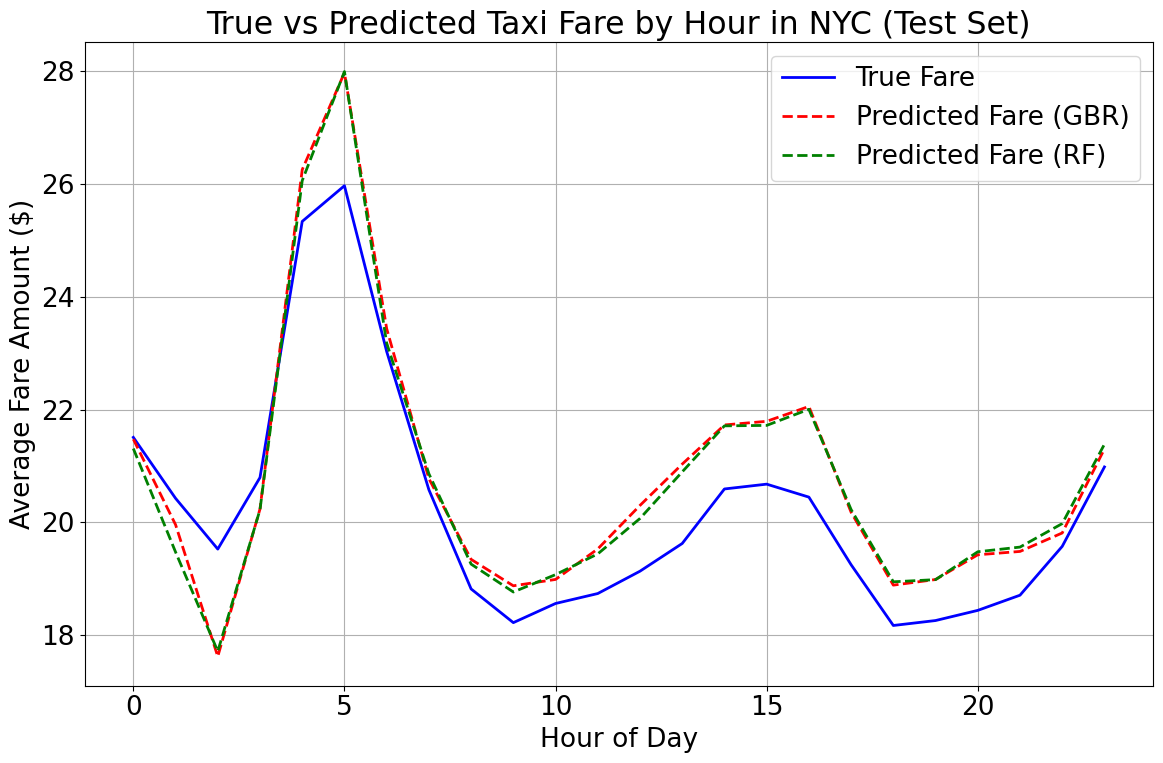

In [48]:
results = pd.DataFrame({
    "hour": X_test_fare["hour"].values,   # pull hour column from X_test
    "true_fare": y_test_fare.values,
    "pred_fare_gbr": y_pred_gbr,
    "pred_fare_rf": y_pred_rf
})

# Group by hour to get average fares per hour
hourly_avg = results.groupby("hour").mean().reset_index()
plt.rcParams.update({"font.size": 19})
# Plot
plt.figure(figsize=(12, 8))
plt.plot(hourly_avg["hour"], hourly_avg["true_fare"], label="True Fare", color="blue", linewidth=2)
plt.plot(hourly_avg["hour"], hourly_avg["pred_fare_gbr"], label="Predicted Fare (GBR)", linestyle="--", color="red", linewidth=2)
plt.plot(hourly_avg["hour"], hourly_avg["pred_fare_rf"], label="Predicted Fare (RF)", linestyle="--", color="green", linewidth=2)



plt.xlabel("Hour of Day")
plt.ylabel("Average Fare Amount ($)")
plt.title("True vs Predicted Taxi Fare by Hour in NYC (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/Predict_Fare.png", dpi=300, bbox_inches="tight")
plt.show()

### Tip


In [32]:
tip = tip.withColumn("hour", col("hour").cast("int"))
tip_pd = tip.toPandas()

In [ ]:
tip_pd['date'] = pd.to_datetime(tip_pd['date'])

# Extract month and season
tip_pd['month'] = tip_pd['date'].dt.month

def date_to_season(date):
    """
    Map date to its season.

    Args:
        date (date): A pandas timestamp object.

    Returns:
        str: The season label ('autumn', 'winter', 'spring', or 'unknown').
    """
    if pd.Timestamp('2024-10-01') <= date <= pd.Timestamp('2024-12-15'):
        return 'autumn'
    elif pd.Timestamp('2024-12-15') < date <= pd.Timestamp('2025-03-15'):
        return 'winter'
    elif pd.Timestamp('2025-03-15') < date <= pd.Timestamp('2025-03-31'):
        return 'spring'

tip_pd['season'] = tip_pd['date'].apply(date_to_season)
tip_pd['weekday'] = tip_pd['date'].dt.weekday

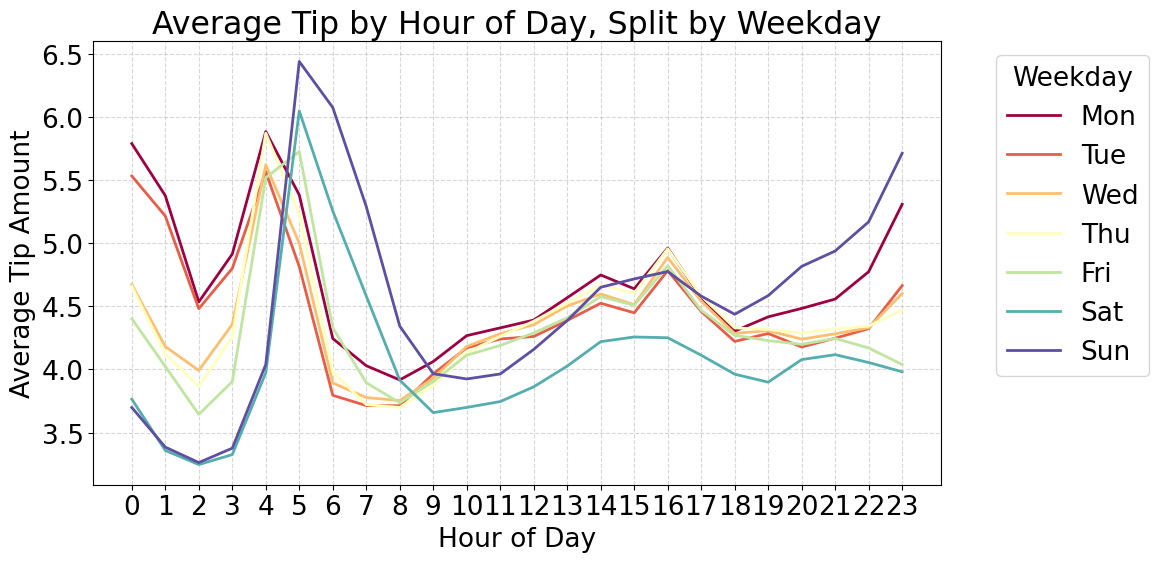

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Checking the relationship between weekday and tip amount
# Group by weekday + hour
tip_weekday_hour = (
    tip_pd.groupby(['weekday', 'hour'])['avg_tip_amount']
    .mean()
    .reset_index()
)

# Map weekday numbers to names
weekday_map = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
weekday_order = [0, 1, 2, 3, 4, 5, 6]
colors = plt.cm.Spectral(np.linspace(0, 1, len(weekday_order)))

plt.figure(figsize=(12,6))
for wd, color in zip(weekday_order, colors):
    group = tip_weekday_hour[tip_weekday_hour["weekday"] == wd]
    plt.plot(group["hour"], group["avg_tip_amount"], 
             label=weekday_map[wd], color=color, linewidth=2)

plt.xticks(range(0,24))
plt.xlabel("Hour of Day")
plt.ylabel("Average Tip Amount")
plt.title("Average Tip by Hour of Day, Split by Weekday")
plt.legend(title="Weekday", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("plots/Avg_tip_over_hour_weekday.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
tip_X = tip_pd[['hour','avg_dew_point','weekday', 'avg_precipitation','is_holiday','season']]
tip_y = tip_pd['avg_tip_amount']

# Encode categorical features using one hot encoding
tip_X = pd.get_dummies(tip_X, columns=['is_holiday','season','weekday'], drop_first=True)

# Train-test split
X_train = tip_X[tip_pd['date'] <= '2025-03-01']
y_train = tip_y[tip_pd['date'] <= '2025-03-01']

# Predict for a future day
X_test = tip_X[tip_pd['date'] > '2025-03-01']
y_test = tip_y[tip_pd['date'] > '2025-03-01']

#### 1. Random Forest Regressor

In [36]:
param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [10, 15, 20, None],       # depth of each tree
            'min_samples_leaf': [1, 3, 5]}
rf = RandomForestRegressor(random_state=42, n_jobs=-1) # Set random_state for reproducibility

grid_search_3 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,  # time-series aware split
    n_jobs=-1,
    verbose=2
)
grid_search_3.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search_3.best_params_)
best_mse = -grid_search_3.best_score_
print("Best CV score (MSE):", best_mse)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.9s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.9s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.9s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.9s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   1.0s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.2s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.5s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.7s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.8s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   2.3s
[CV] END .max_depth=10, min_samples_leaf=1, n_e

In [38]:
best_rf_tip = grid_search_3.best_estimator_
y_pred_rf_tip= best_rf_tip.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_rf_tip)
rmse_test = np.sqrt(mse_test)
print("Test RMSE:", rmse_test)

Test RMSE: 0.4647766760250152


#### 2. Hist Gradient Boosting Regressor

In [39]:
param_grid = {
    "max_depth": [10, 15, 20, None],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [200, 300, 500],
    "min_samples_leaf": [1, 3, 5]
}

gbr = HistGradientBoostingRegressor(random_state=42)

grid_search_4 = GridSearchCV(
    gbr,
    param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

# Fit search
grid_search_4.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search_4.best_params_)
best_mse_hgbr = -grid_search_4.best_score_
print("Best CV score (MSE):", best_mse_hgbr )

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=3; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=3; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=3; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=1; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=5; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=10, max_iter=200, min_samples_leaf=5; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=1

In [40]:
best_gbr_tip = grid_search_4.best_estimator_
y_pred_gbr_tip = best_gbr_tip.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_gbr_tip)
rmse_test = np.sqrt(mse_test)
print("Test RMSE:", rmse_test)

Test RMSE: 0.4615137424349461


#### 3. Evaluation

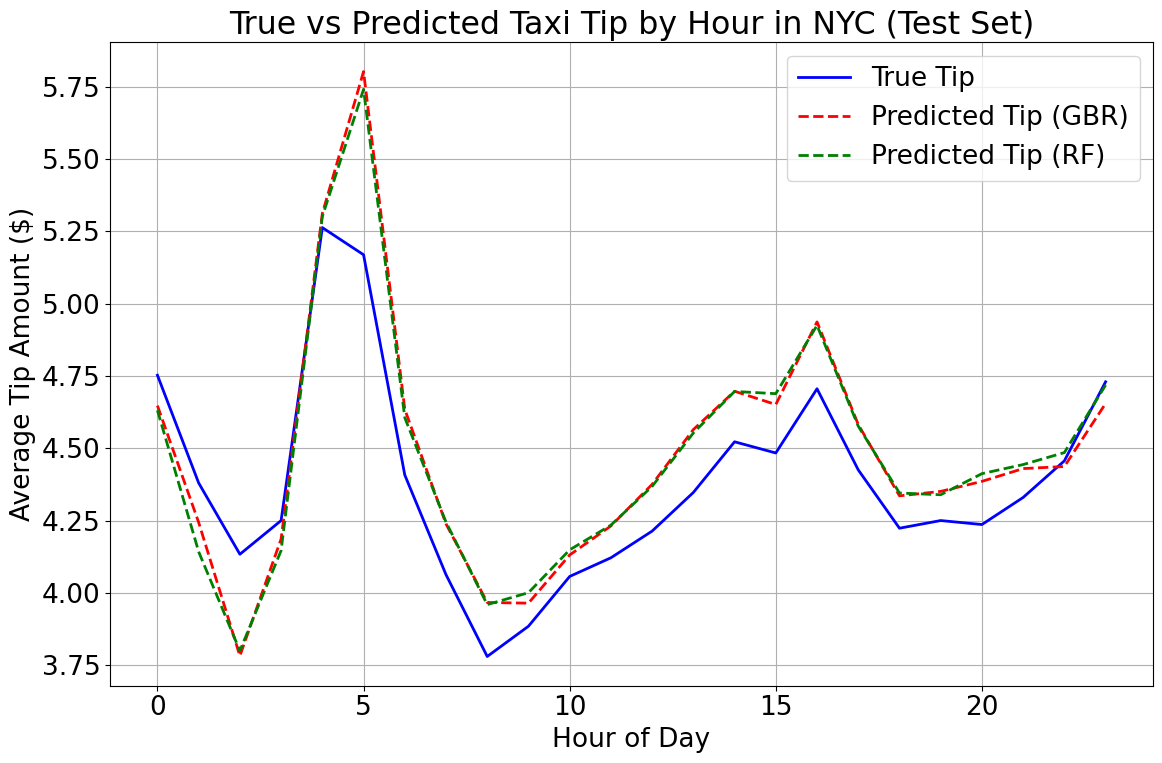

In [49]:
results = pd.DataFrame({
    "hour": X_test["hour"].values, 
    "true_tip": y_test.values,
    "pred_tip_gbr": y_pred_gbr_tip,
    "pred_tip_rf": y_pred_rf_tip
})

# Group by hour to get average fares per hour
hourly_avg = results.groupby("hour").mean().reset_index()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(hourly_avg["hour"], hourly_avg["true_tip"], label="True Tip", color="blue", linewidth=2)
plt.plot(hourly_avg["hour"], hourly_avg["pred_tip_gbr"], label="Predicted Tip (GBR)", linestyle="--", color="red", linewidth=2)
plt.plot(hourly_avg["hour"], hourly_avg["pred_tip_rf"], label="Predicted Tip (RF)", linestyle="--", color="green", linewidth=2)



plt.xlabel("Hour of Day")
plt.ylabel("Average Tip Amount ($)")
plt.title("True vs Predicted Taxi Tip by Hour in NYC (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/Predict_Tip.png", dpi=300, bbox_inches="tight")
plt.show()